# Classification Models
This Jupyter Notebook creates supervised classification models at the admission level and at the patient level.

When using patient-level data, the data is aggregated across all admissions that are available in the dataset. The majority of columns are binary, and so the `max()` function is used to track the presence of a given field in the patient record. Numeric fields are aggregated using the `mean()`.

In [ ]:
### COMMENT OUT IF RUNNING LOCALLY (NOT VIA GOOGLE COLAB) ###
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using GPU.")
else:
    print("TensorFlow is using CPU.")


TensorFlow version: 2.17.0
TensorFlow is using CPU.


In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import recall_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# used for base estimator for AdaBoost
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score, \
roc_curve, make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy.sparse import csr_matrix
from sklearn.multioutput import MultiOutputClassifier

def read_csv(csv_file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)
    print(csv_file_path)
    print('Shape:', df.shape)
    print(df.head())
    return df

## Read in the Data

In [ ]:
input_data = read_csv('/content/drive/MyDrive/final_dfs/final_static_data.csv')

<ipython-input-4-b2c3745cbfaa>:25: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


/content/drive/MyDrive/final_dfs/final_static_data.csv
Shape: (109751, 1789)
   subject_id            charttime     hadm_id         duration  \
0    16925328  2151-05-25 15:03:00  20000024.0   75120000000000   
1    11146739  2190-01-15 14:41:00  20000057.0  255480000000000   
2    14546051  2130-12-10 00:00:00  20000069.0  175560000000000   
3    13074106  2135-05-20 00:00:00  20000102.0  296880000000000   
4    13559141  2174-12-06 00:00:00  20000347.0  177780000000000   

     microbiology_orgname curr_service   care_unit_group disposition  \
0                     NaN          MED         Emergency        HOME   
1                     NaN          MED         Emergency     UNKNOWN   
2  GRAM POSITIVE BACTERIA          OBS  Labor & Delivery        HOME   
3                     NaN          OBS  Labor & Delivery        HOME   
4     SERRATIA MARCESCENS          MED         Emergency     UNKNOWN   

   is_ed_visit  is_urgent_lab_event  ...                       race  \
0            0  

In [ ]:
output_data = read_csv('/content/drive/MyDrive/final_dfs/target_outputs.csv')

/content/drive/MyDrive/final_dfs/target_outputs.csv
Shape: (19076, 5)
   subject_id  preeclampsia_output  preterm_output  hemorrhage_output  \
0    16925328                    0               0                  0   
1    11146739                    0               0                  0   
2    14546051                    0               0                  0   
3    13074106                    0               1                  1   
4    13559141                    0               0                  0   

   has_adverse_outcome  
0                    0  
1                    0  
2                    0  
3                    1  
4                    0  


## Prepare the data

In [ ]:
for col in input_data.columns:
    if pd.api.types.is_float_dtype(input_data[col]):
            input_data[col] = input_data[col].astype(int)

In [ ]:
exclude_cols = ['has_adverse_outcome', 'subject_id', 'hadm_id', 'charttime', 'duration', 'age_at_admission', 'mean_patient_weight']
feature_cols = [col for col in input_data.columns.tolist() if col not in exclude_cols]
input_data = pd.get_dummies(input_data, columns=feature_cols)

In [ ]:
column_to_scale = input_data[['age_at_admission', 'mean_patient_weight']]

scaler = StandardScaler()
scaled_column = scaler.fit_transform(column_to_scale)

scaled_column_df = pd.DataFrame(scaled_column, columns=['age_at_admission', 'mean_patient_weight'], index=input_data.index)
input_data = input_data.drop(columns=['age_at_admission', 'mean_patient_weight'])

# Add the scaled column back to the DataFrame
input_data = pd.concat([input_data, scaled_column_df], axis=1)

In [ ]:
# sort and group by subject
# then create sequences where each sequence corresponds to a series of hadm_id events
input_data = input_data.sort_values(by=['subject_id', 'charttime'])

In [ ]:
admission_counts = input_data.groupby('subject_id').size()
subject_ids = admission_counts[admission_counts >= 2].index
filtered_input_data = input_data[input_data['subject_id'].isin(subject_ids)]

In [ ]:
filtered_input_data.shape

(106786, 3639)

### Create Aggregated Representation of the data
The current data representation aggregates the data at the admission level. We also want to look at the results when aggregated against all visits that a patient has, since the number of admissions varies from patient to patient.

In [ ]:
boolean_cols = filtered_input_data.select_dtypes(include=[bool]).columns.tolist()
print(len(boolean_cols))

3633


In [ ]:
def aggregate_by_subject(df):
    """
    Aggregates a DataFrame by subject_id.
    """
    numeric_cols = ['age_at_admission', 'mean_patient_weight']
    boolean_cols = df.select_dtypes(include=[bool]).columns.tolist()
    # Define aggregation functions
    aggregation_functions = {col: 'mean' for col in numeric_cols}
    aggregation_functions.update({col: 'max' for col in boolean_cols})

    aggregated_df = df.groupby('subject_id').agg(aggregation_functions).reset_index()
    aggregated_df.sort_values(by='subject_id', inplace=True)
    aggregated_df.drop(columns=['subject_id'], inplace=True)

    return aggregated_df

In [ ]:
# aggregate input data
filtered_input_data.head()
# drop charttime, hadm_id and duration since no longer needed
agg_input_data = filtered_input_data.drop(columns=['charttime', 'duration'])
X_agg = aggregate_by_subject(agg_input_data)
X_agg = X_agg.astype(np.float32)
# sort output data by subject_id so that it aligns with the input data
filtered_output_data = output_data[output_data['subject_id'].isin(filtered_input_data['subject_id'])].sort_values(by=['subject_id'])
# create X and y representations
y_agg = filtered_output_data[['has_adverse_outcome']]
y_agg_multi = filtered_output_data[['preeclampsia_output', 'preterm_output', 'hemorrhage_output']]

In [ ]:
print(X_agg.shape)
print(y_agg.shape)
print(y_agg_multi.shape)

(16111, 3635)
(16111, 1)
(16111, 3)


In [ ]:
filtered_input_data = pd.merge(filtered_input_data, output_data, on='subject_id', how='left')

In [ ]:
filtered_input_data['has_adverse_outcome'].value_counts()

,count
has_adverse_outcome,
0,91716
1,15070


In [ ]:
# define feature cols
exclude_cols = ['has_adverse_outcome', 'subject_id', 'hadm_id', 'charttime', 'duration']
feature_cols = [col for col in filtered_input_data.columns.tolist() if col not in exclude_cols]

In [ ]:
# drop unnecessary columns
filtered_input_data = filtered_input_data.drop(columns=['subject_id', 'charttime', 'hadm_id', 'duration'])
output_cols = output_data.columns
X = filtered_input_data[[col for col in filtered_input_data.columns if col not in output_cols]]
y = filtered_input_data[['has_adverse_outcome']]

In [ ]:
X = X.astype(np.float32)

In [ ]:
## define multi-class output
y_multi = filtered_input_data[['preeclampsia_output', 'preterm_output', 'hemorrhage_output']]

In [ ]:
y_names = y.columns.tolist()
y_multi_names = y_multi.columns.tolist()
y_agg_names = y_agg.columns.tolist()
y_agg_multi_names = y_agg_multi.columns.tolist()

### General Functions for Classifiers

In [ ]:
SAVE_FOLDER = 'capstone_imgs'
def gen_roc_curve(y_test, y_prob, plot_title, file_name):
  auc_score = roc_auc_score(y_test, y_prob)
  fpr, tpr, thresholds = roc_curve(y_test, y_prob)

  plt.figure(figsize=(10, 6))
  plt.plot(fpr, tpr, color='blue', label=f'ROC Curve(AUC = {auc_score:.2f})')
  plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(plot_title)
  plt.legend(loc='lower right')
  plt.savefig(f'/content/drive/My Drive/{SAVE_FOLDER}/{file_name}', bbox_inches='tight')
  plt.show()

def gen_roc_curve_multi(y_test, y_prob, plot_title, file_name, column_names):
    """
    Handle ROC Curve for each label independently, and plot separately.
    """
    num_labels = y_test.shape[1]
    plt.figure(figsize=(10, 6))

    # plot separately for each label
    for i in range(num_labels):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_prob[:, i])
        auc_score = roc_auc_score(y_test[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, label=f'{column_names[i]} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plot_title)
    plt.legend(loc='lower right')
    plt.savefig(f'/content/drive/My Drive/{SAVE_FOLDER}/{file_name}_{column_names[i]}.png', bbox_inches='tight')
    plt.show()

def gen_confusion_matrix(y_test, y_pred, plot_title, file_name):

  cm = confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Class 0', 'Class 1'],
              yticklabels=['Class 0', 'Class 1'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(plot_title)
  plt.savefig(f'/content/drive/My Drive/{SAVE_FOLDER}/{file_name}', bbox_inches='tight')
  plt.show()

def gen_confusion_matrix_multi(y_test, y_pred, plot_title, file_name, column_names):

    num_labels = y_test.shape[1]

    for i in range(num_labels):
        cm = confusion_matrix(y_test[:, i], y_pred[:, i])

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Class 0', 'Class 1'],
                    yticklabels=['Class 0', 'Class 1'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'{plot_title} - {column_names[i]}')
        plt.savefig(f'/content/drive/My Drive/{SAVE_FOLDER}/{file_name}_{column_names[i]}.png', bbox_inches='tight')
        plt.show()

def gen_feature_importance(pipeline, X, file_name):
  # calculate feature importance
  importances = pipeline.named_steps['classifier'].feature_importances_
  features = X.columns

  feature_importance_pairs = list(zip(features, importances))
  sorted_features = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

  # top 10 features
  top_features = sorted_features[:10]

  # unzip into separate lists
  top_feature_names, top_importances = zip(*top_features)

  plt.figure(figsize=(12, 8))
  plt.barh(top_feature_names, top_importances, color='skyblue')
  plt.xlabel('Importance')
  plt.title('Top 10 Feature Importances')
  plt.gca().invert_yaxis()
  plt.savefig(f'/content/drive/My Drive/{SAVE_FOLDER}/{file_name}', bbox_inches='tight')
  plt.show()

def gen_feature_importance_multi(pipeline, X, file_name):
  importances = []
  feature_names = X.columns
  for i, estimator in enumerate(pipeline.named_steps['classifier'].estimators_):
      if hasattr(estimator, 'feature_importances_'):
          importances.append(estimator.feature_importances_)
      else:
          importances.append(None)
          print(f"Estimator for output {i} does not support feature importances.")

  avg_importances = np.mean(np.array(importances), axis=0)

  importances_df = pd.DataFrame({
      'Feature': feature_names,
      'Importance': avg_importances
  })
  # sort by importance
  top_10_features= importances_df.sort_values(by='Importance', ascending=False).head(10)

  plt.figure(figsize=(12, 8))
  plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
  plt.xlabel('Importance')
  plt.title('Top 10 Features by Importance')
  plt.gca().invert_yaxis()
  plt.savefig(file_name, bbox_inches='tight')
  plt.show()

def calc_metrics(y_test, y_pred, y_prob):
  auc_score = roc_auc_score(y_test, y_prob)
  recall = recall_score(y_test, y_pred)

  print("AUC:", auc_score)
  print("Recall:", recall)
  print(classification_report(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))

def calc_metrics_multi(y_test, y_pred, y_prob):
  # macro == calculate AUC for each label and then take average
  auc_score = roc_auc_score(y_test, y_prob, average="macro")
  recall = recall_score(y_test, y_pred, average="macro")

  print("AUC:", auc_score)
  print("Recall:", recall)
  print(classification_report(y_test, y_pred))

In [ ]:
def print_cv_results(cv_results):
  print("Cross-validation results, averaged over 5 folds:")
  print(f"Mean AUC: {np.mean(cv_results['test_roc_auc'])}")
  print(f"Mean recall: {np.mean(cv_results['test_recall'])}")

In [ ]:
# custom scoreres used for multilabel analysis
# Define custom scorers
def weighted_auc(y_true, y_pred):
    return roc_auc_score(y_true, y_pred, average='weighted', multi_class='ovr')

def weighted_recall(y_true, y_pred):
    return recall_score(y_true, y_pred, average='weighted')

auc_scorer = make_scorer(weighted_auc, needs_proba=True)
recall_scorer = make_scorer(weighted_recall, needs_proba=False)

### Cross-validation
- use the metrics from cross-validation to determine whether there is a significant difference between the cross-validation metrics and the test set metrics (ex. performs well on cv but not on test set would mean poor generalizability of the model)

## Random Forest Classifier with SMOTE on Admissions

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=23)
smote = SMOTE(random_state=23)

pipeline = Pipeline([
    ('smote', smote),
    ('classifier', rf)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
# recall calculated for the positive class
cv_results = cross_validate(pipeline, X_train, y_train, cv=cv,
                            scoring=['roc_auc', 'f1', 'recall'],
                            return_train_score=False)

print_cv_results(cv_results)


pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Cross-validation results, averaged over 5 folds:
Mean AUC: 0.8515392543749851
Mean F1 score: 0.3761369153221534
Mean recall: 0.3506546161106463


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('smote', SMOTE(random_state=23)),
                ('classifier', RandomForestClassifier(random_state=23))])

In [ ]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

calc_metrics(y_test, y_pred, y_prob)

AUC: 0.8600951589283996
Recall: 0.39046133273902384
              precision    recall  f1-score   support

           0       0.90      0.91      0.91     27549
           1       0.42      0.39      0.40      4487

    accuracy                           0.84     32036
   macro avg       0.66      0.65      0.66     32036
weighted avg       0.83      0.84      0.84     32036

[[25115  2434]
 [ 2735  1752]]


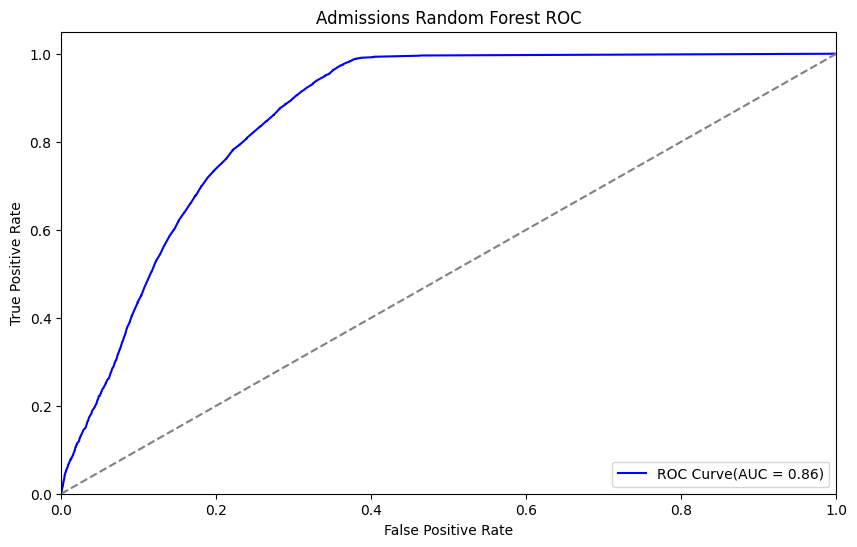

In [ ]:
gen_roc_curve(y_test, y_prob, 'Admissions Random Forest ROC', 'admissions_rf_binary_roc.png')

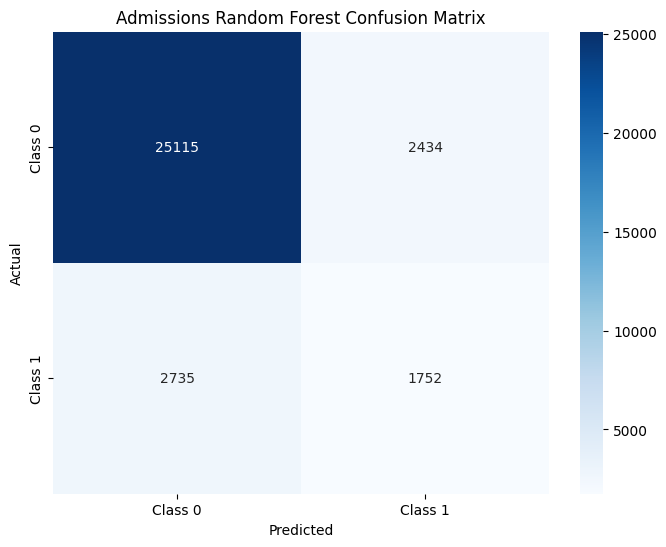

In [ ]:
gen_confusion_matrix(y_test, y_pred, 'Admissions Random Forest Confusion Matrix', 'admissions_rf_binary_matrix.png')

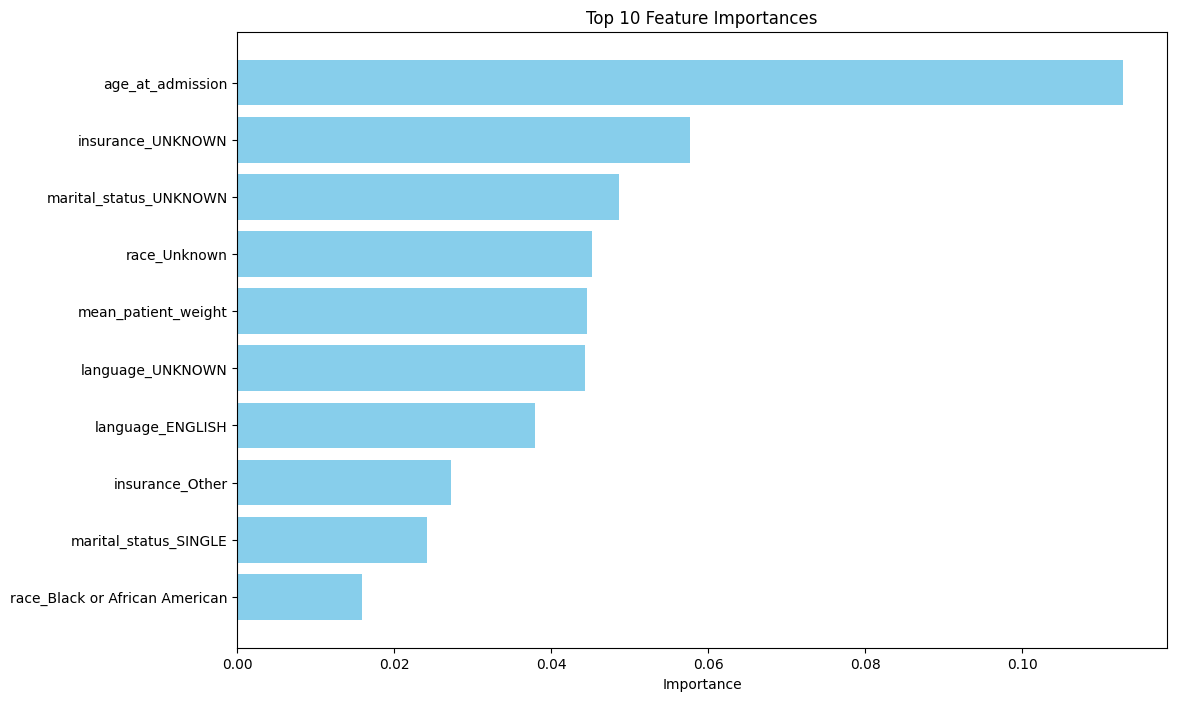

In [ ]:
gen_feature_importance(pipeline, X, 'admissions_rf_binary_importance.png')

## Random Forest Classifier with SMOTE on Aggregated Admissions

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=23)
smote = SMOTE(random_state=23)

pipeline = Pipeline([
    ('smote', smote),
    ('classifier', rf)
])

X_train, X_test, y_train, y_test = train_test_split(X_agg, y_agg, test_size=0.3, random_state=23)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
cv_results = cross_validate(pipeline, X_train, y_train, cv=cv,
                            scoring=['roc_auc', 'f1', 'recall'],
                            return_train_score=False)

print_cv_results(cv_results)

pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Cross-validation results, averaged over 5 folds:
Mean AUC: 0.8126098980373595
Mean F1 score: 0.24831799044077246
Mean recall: 0.15608954272080572


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('smote', SMOTE(random_state=23)),
                ('classifier', RandomForestClassifier(random_state=23))])

In [ ]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

calc_metrics(y_test, y_pred, y_prob)

AUC: 0.8084500947822529
Recall: 0.15167930660888407
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      3911
           1       0.60      0.15      0.24       923

    accuracy                           0.82      4834
   macro avg       0.71      0.56      0.57      4834
weighted avg       0.79      0.82      0.77      4834

[[3817   94]
 [ 783  140]]


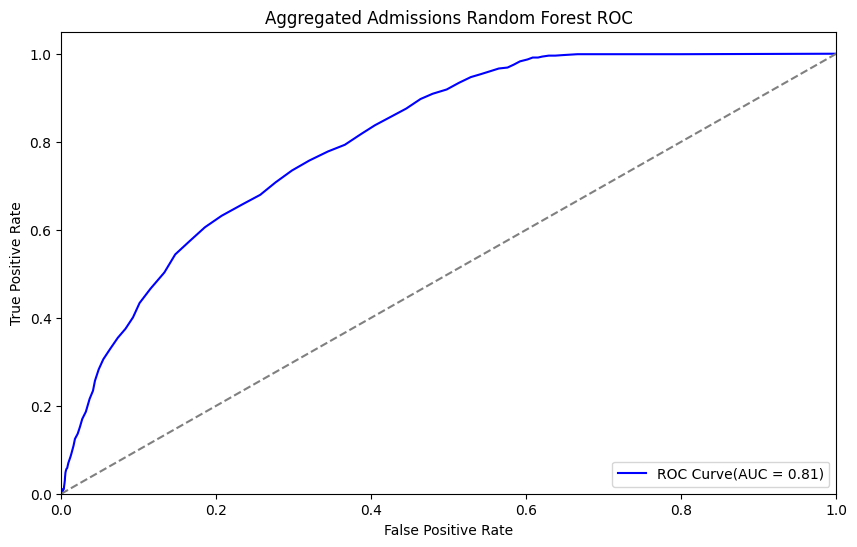

In [ ]:
gen_roc_curve(y_test, y_prob, 'Aggregated Admissions Random Forest ROC', 'agg_admissions_rf_binary_roc.png')

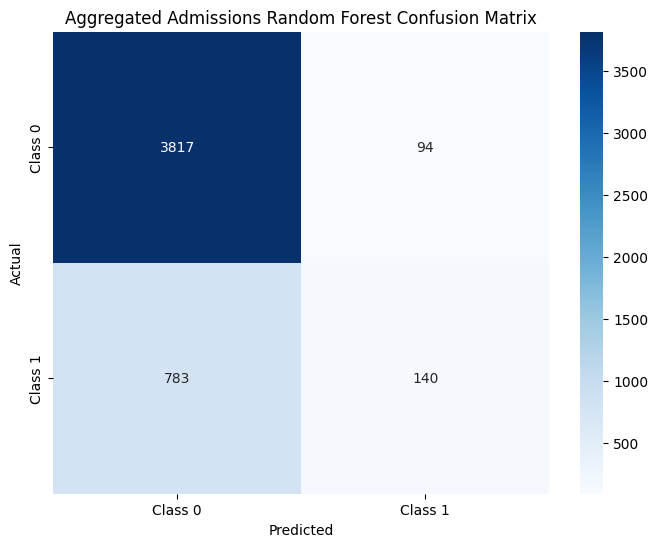

In [ ]:
gen_confusion_matrix(y_test, y_pred, 'Aggregated Admissions Random Forest Confusion Matrix', 'agg_admissions_rf_binary_matrix.png')

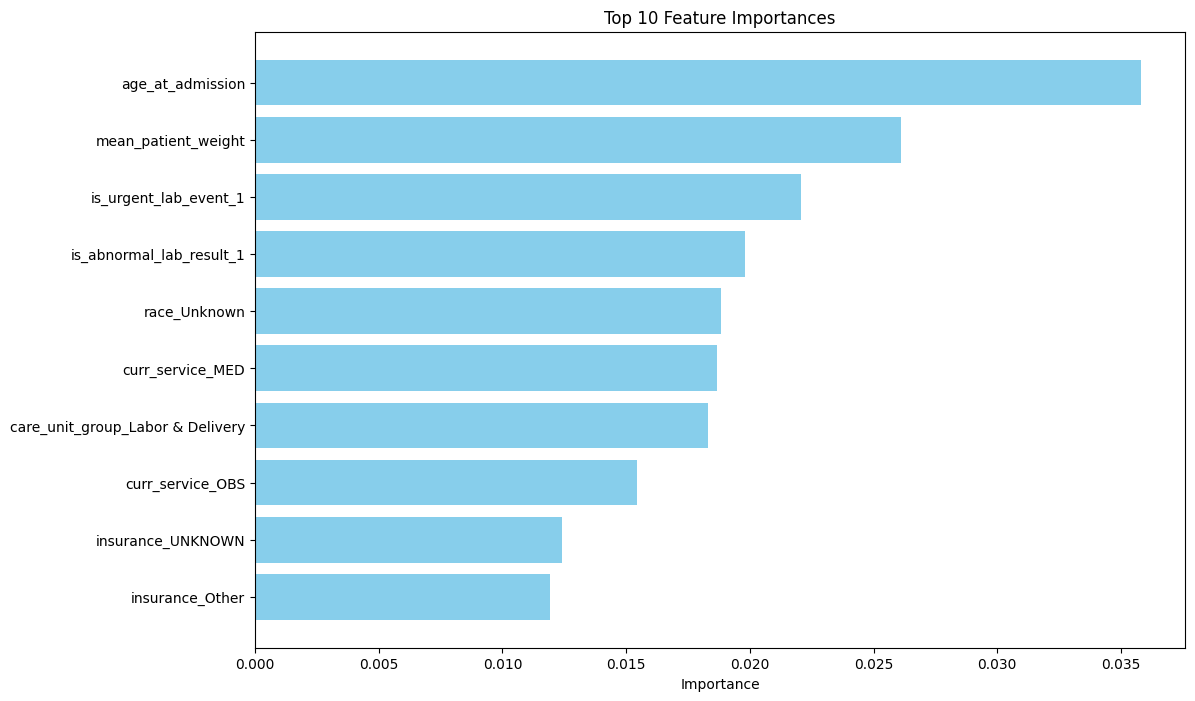

In [ ]:
gen_feature_importance(pipeline, X_agg, 'agg_admissions_rf_binary_importance.png')

## Random Forest Classifier on Admissions (Multi-Label Classifier)
Note - cannot use SMOTE since imblearn does not support multi-target/multi-label problems using SMOTE

In [ ]:
base_estimator = RandomForestClassifier(n_estimators=50, random_state=23)
# used for multilabel classification
multi_output_classifier = MultiOutputClassifier(base_estimator)

# Create the pipeline
pipeline = Pipeline([
    ('classifier', multi_output_classifier)
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_multi, test_size=0.3, random_state=23)

cv = KFold(n_splits=5, shuffle=True, random_state=23)

cv_results = cross_validate(pipeline, X_train, y_train, cv=cv,
                            scoring={'roc_auc': auc_scorer, 'recall': recall_scorer},
                            return_train_score=False)

print_cv_results(cv_results)

# Fit the pipeline
pipeline.fit(X_train, y_train)

Cross-validation results, averaged over 5 folds:
Mean AUC: 0.8366673741465236


KeyError: 'test_f1'

In [ ]:
print_cv_results(cv_results)

Cross-validation results, averaged over 5 folds:
Mean AUC: 0.8366673741465236
Mean recall: 0.10737002317317675


In [ ]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)
# reshape y_prob from list of arrays to 2D array
y_prob = np.array([prob[:, 1] for prob in y_prob]).T

calc_metrics_multi(y_test, y_pred, y_prob)

AUC: 0.850358344097694
Recall: 0.1273335280739987
              precision    recall  f1-score   support

           0       0.78      0.15      0.26      1312
           1       0.46      0.08      0.14      1522
           2       0.60      0.15      0.23      2628

   micro avg       0.61      0.13      0.21      5462
   macro avg       0.61      0.13      0.21      5462
weighted avg       0.60      0.13      0.21      5462
 samples avg       0.02      0.02      0.02      5462



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
calc_metrics_multi(y_test.values, y_pred, y_prob)

AUC: 0.850358344097694
Recall: 0.1273335280739987
              precision    recall  f1-score   support

           0       0.78      0.15      0.26      1312
           1       0.46      0.08      0.14      1522
           2       0.60      0.15      0.23      2628

   micro avg       0.61      0.13      0.21      5462
   macro avg       0.61      0.13      0.21      5462
weighted avg       0.60      0.13      0.21      5462
 samples avg       0.02      0.02      0.02      5462



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_test.head()

,preeclampsia_output,preterm_output,hemorrhage_output
74439,0,0,0
35701,0,0,0
26940,0,0,0
6218,0,0,0
23422,0,0,0


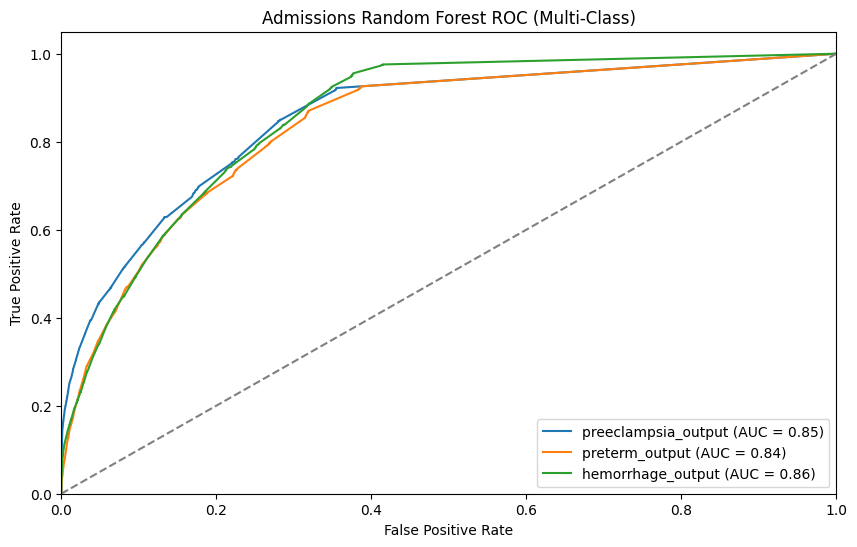

In [ ]:
gen_roc_curve_multi(y_test.values, y_prob, 'Admissions Random Forest ROC (Multi-Class)', 'multi_admissions_rf_roc.png', y_multi_names)

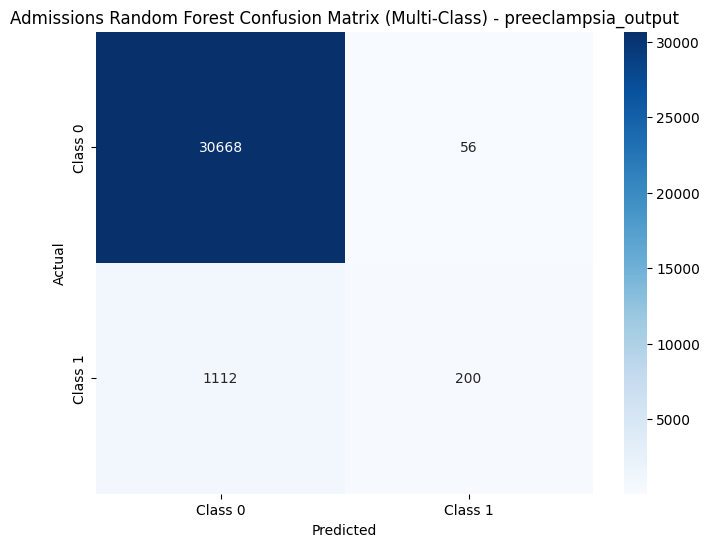

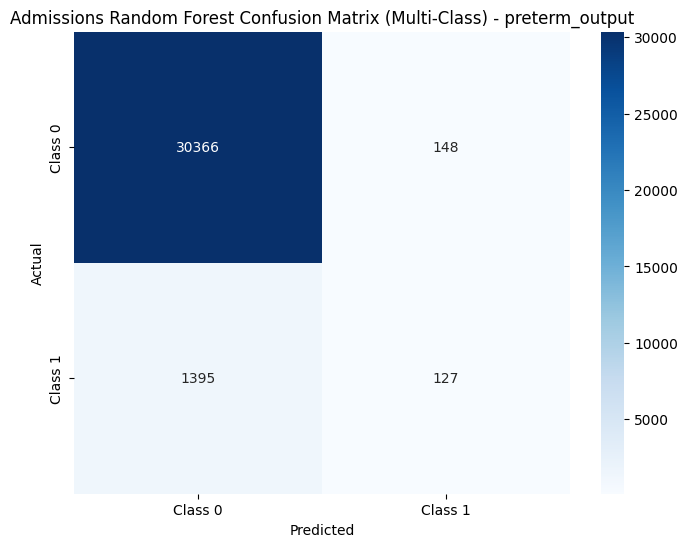

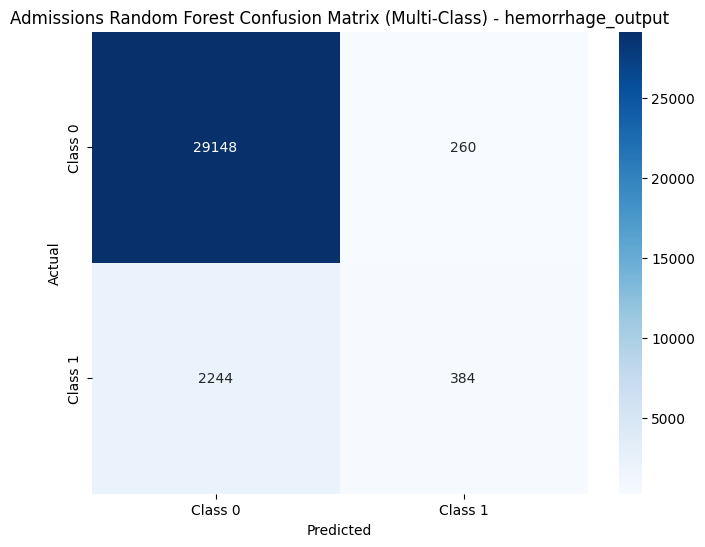

In [ ]:
gen_confusion_matrix_multi(y_test.values, y_pred, 'Admissions Random Forest Confusion Matrix (Multi-Class)', 'multi_admissions_rf_matrix.png', y_multi_names)

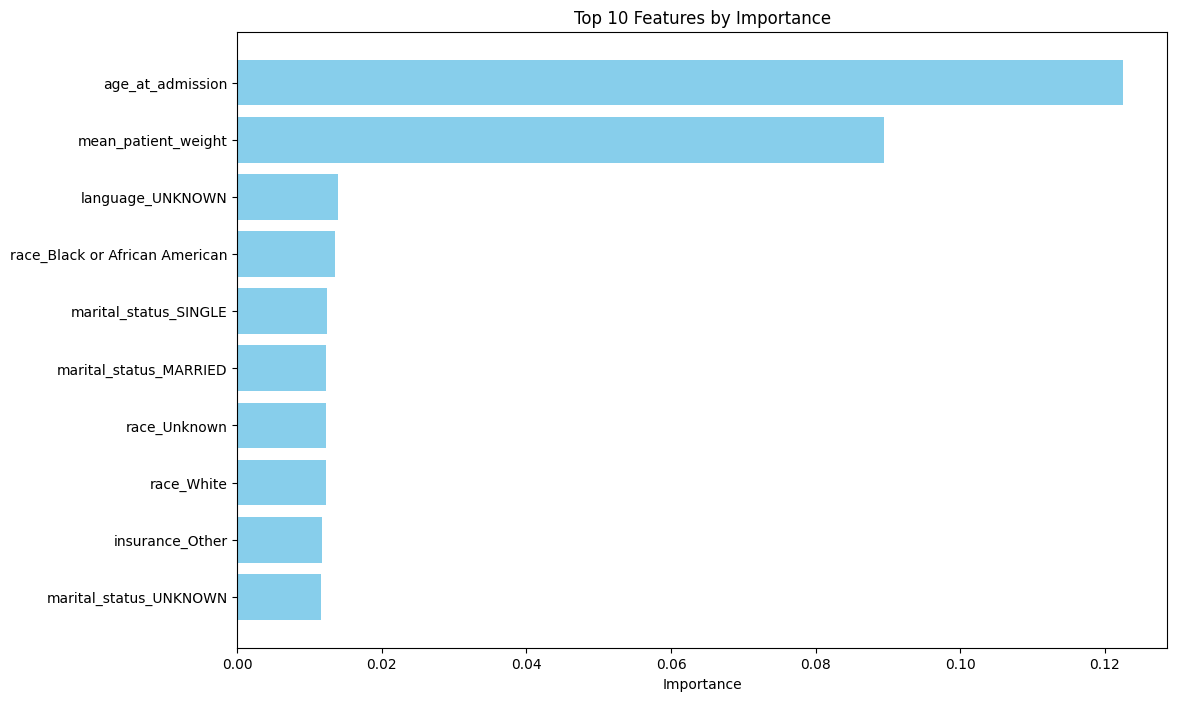

In [ ]:
gen_feature_importance_multi(pipeline, X, 'multi_admissions_rf_importance.png')

## Random Forest Classifier on Aggregated Admissions (Multi-Label Classifier)

In [ ]:
base_estimator = RandomForestClassifier(n_estimators=50, random_state=23)
# used for multilabel classification
multi_output_classifier = MultiOutputClassifier(base_estimator)

# Create the pipeline
pipeline = Pipeline([
    ('classifier', multi_output_classifier)
])

X_train, X_test, y_train, y_test = train_test_split(X_agg, y_agg_multi, test_size=0.3, random_state=23)

cv = KFold(n_splits=5, shuffle=True, random_state=23)

cv_results = cross_validate(pipeline, X_train, y_train, cv=cv,
                            scoring={'roc_auc': auc_scorer, 'recall': recall_scorer},
                            return_train_score=False)

print_cv_results(cv_results)

pipeline.fit(X_train, y_train)

Cross-validation results, averaged over 5 folds:
Mean AUC: 0.8149972939931764
Mean recall: 0.09712149153183987


Pipeline(steps=[('classifier',
                 MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=50,
                                                                        random_state=23)))])

In [ ]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)
# reshape y_prob from list of arrays to 2D array
y_prob = np.array([prob[:, 1] for prob in y_prob]).T

In [ ]:
calc_metrics_multi(y_test.values, y_pred, y_prob)

AUC: 0.8111134171645923
Recall: 0.08330298063497844
              precision    recall  f1-score   support

           0       0.95      0.13      0.23       289
           1       0.00      0.00      0.00       289
           2       0.86      0.12      0.21       532

   micro avg       0.83      0.09      0.16      1110
   macro avg       0.60      0.08      0.15      1110
weighted avg       0.66      0.09      0.16      1110
 samples avg       0.02      0.02      0.02      1110



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


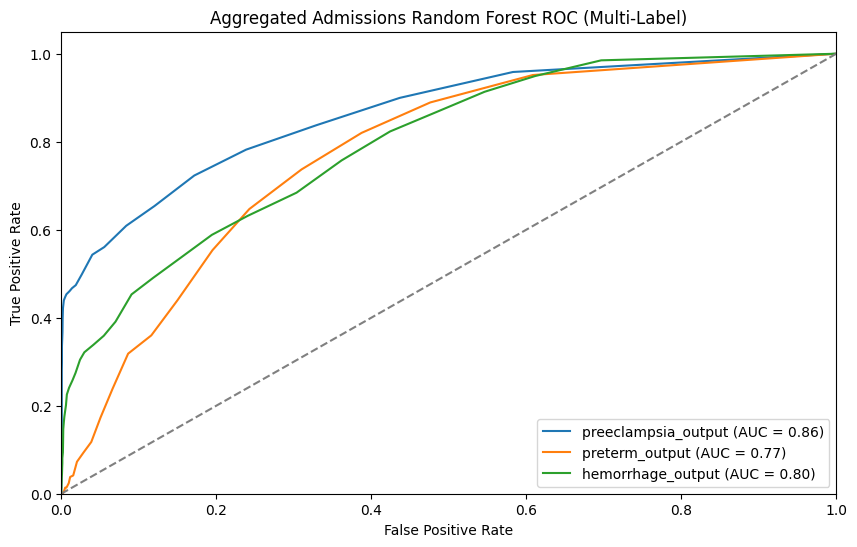

In [ ]:
gen_roc_curve_multi(y_test.values, y_prob, 'Aggregated Admissions Random Forest ROC (Multi-Label)',
                    'agg_multi_admissions_rf_roc.png', y_agg_multi_names)

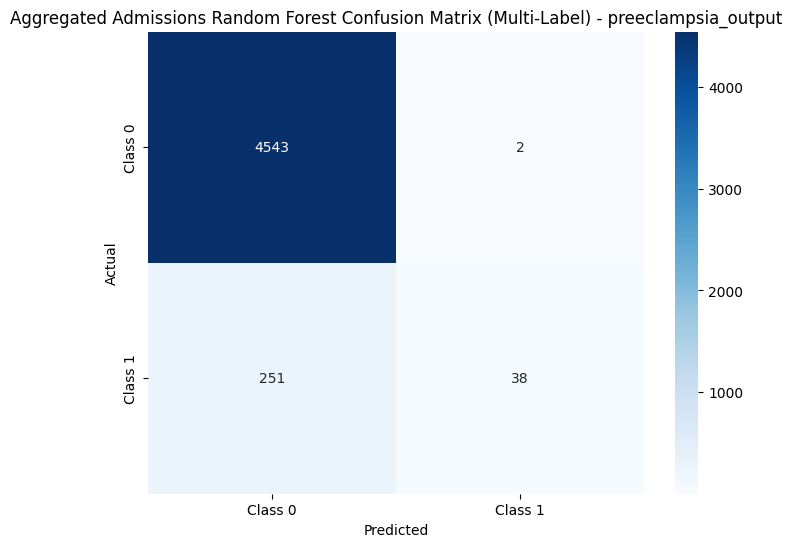

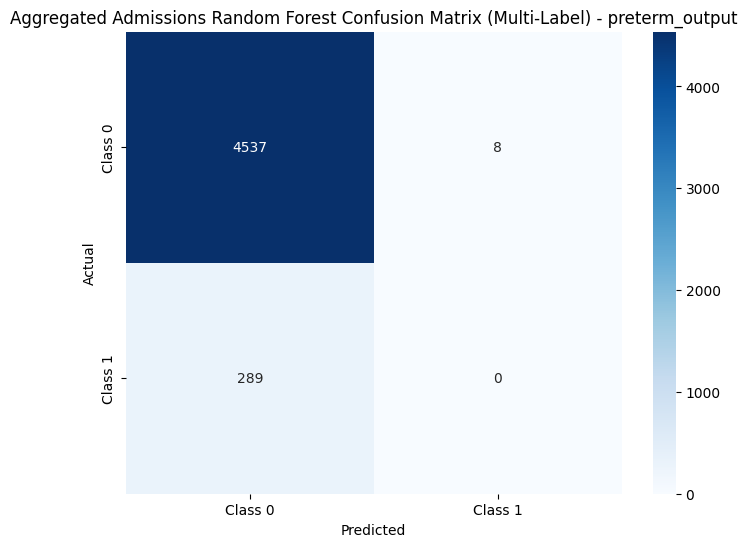

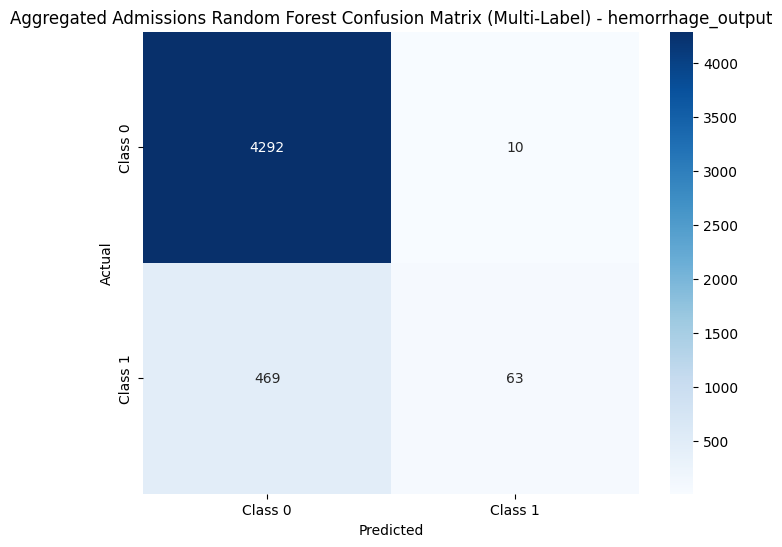

In [ ]:
gen_confusion_matrix_multi(y_test.values, y_pred,
                           'Aggregated Admissions Random Forest Confusion Matrix (Multi-Label)',
                           'agg_multi_admissions_rf_matrix.png', y_agg_multi_names)

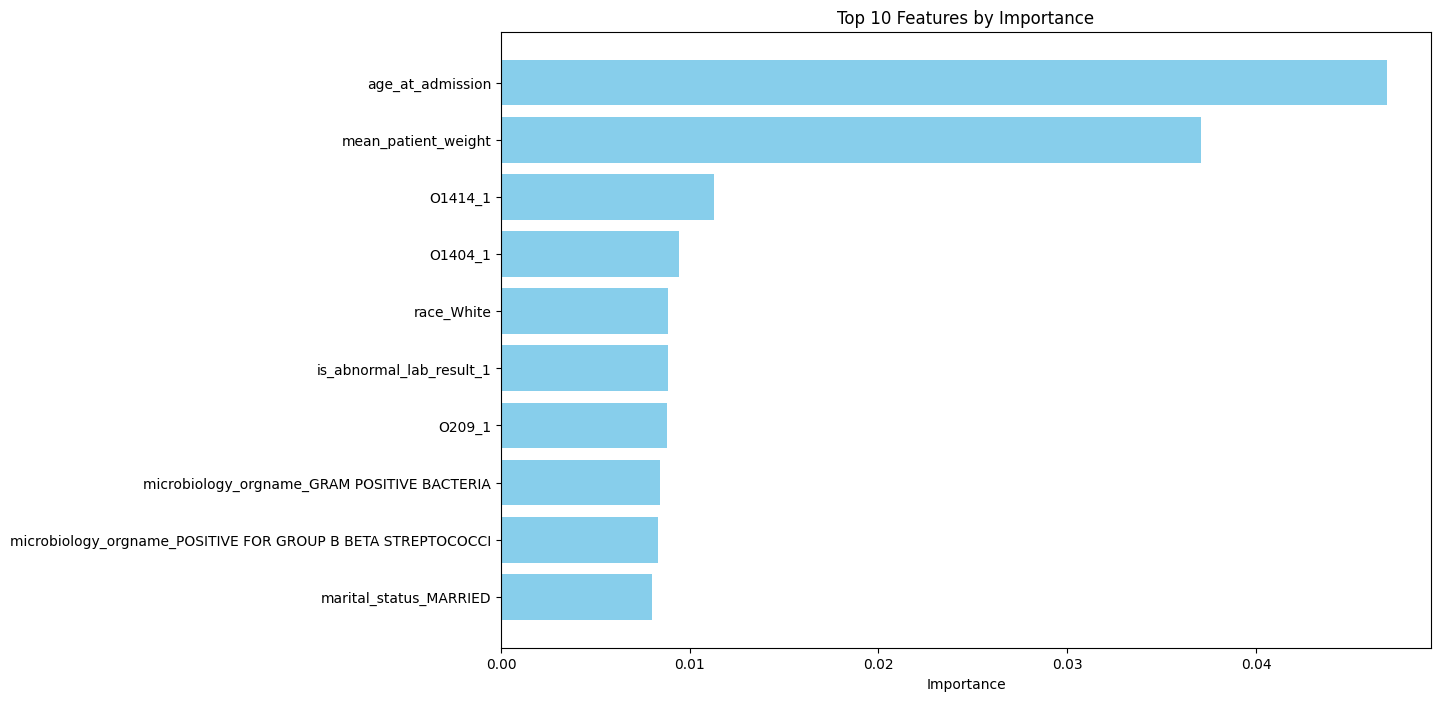

In [ ]:
gen_feature_importance_multi(pipeline, X_agg, 'agg_multi_admissions_rf_importance.png')

## AdaBoost Classifier with SMOTE on Admissions

In [ ]:
# base estimator - use simple base estimator to avoid overfitting
base_estimator = DecisionTreeClassifier(max_depth=1)
# start with a modest number of estimators to reduce model complexity
ada_boost = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, random_state=23)
smote = SMOTE(random_state=23)

pipeline = Pipeline([
    ('smote', smote),
    ('classifier', ada_boost)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
cv_results = cross_validate(pipeline, X_train, y_train, cv=cv,
                            scoring=['roc_auc', 'f1', 'recall'],
                            return_train_score=False)

print_cv_results(cv_results)

pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarnin

Cross-validation results, averaged over 5 folds:
Mean AUC: 0.8231255004292365
Mean recall: 0.8627048298364219


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Pipeline(steps=[('smote', SMOTE(random_state=23)),
                ('classifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                    random_state=23))])

In [ ]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

calc_metrics(y_test, y_pred, y_prob)

AUC: 0.8316025194017204
Recall: 0.863605972810341
              precision    recall  f1-score   support

           0       0.97      0.68      0.80     27549
           1       0.31      0.86      0.45      4487

    accuracy                           0.71     32036
   macro avg       0.64      0.77      0.63     32036
weighted avg       0.88      0.71      0.75     32036

[[18834  8715]
 [  612  3875]]


In [ ]:
gen_roc_curve(y_test, y_prob, 'Admissions AdaBoost ROC', 'admissions_ada_binary_roc.png')

In [ ]:
gen_confusion_matrix(y_test, y_pred, 'Admissions AdaBoost Confusion Matrix', 'admissions_ada_binary_matrix.png')

In [ ]:
gen_feature_importance(pipeline, X, 'admissions_ada_binary_importance.png')

## AdaBoost Classifier on Admissions (Multi-Label Classifier)
Note - cannot use SMOTE since imblearn does not support multi-target/multi-label problems using SMOTE

In [ ]:
# base estimator - use simple base estimator to avoid overfitting
base_estimator = DecisionTreeClassifier(max_depth=1)
# start with a modest number of estimators to reduce model complexity
ada_boost = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, random_state=23)

# Use MultiOutputClassifier to handle multilabel classification
multi_output_classifier = MultiOutputClassifier(ada_boost)
pipeline = Pipeline([
    ('classifier', multi_output_classifier)
])

X_train, X_test, y_train, y_test = train_test_split(X, y_multi, test_size=0.3, random_state=23)

cv = KFold(n_splits=5, shuffle=True, random_state=23)

cv_results = cross_validate(pipeline, X_train, y_train, cv=cv,
                            scoring={'roc_auc': auc_scorer, 'recall': recall_scorer},
                            return_train_score=False)

print_cv_results(cv_results)

pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

Cross-validation results, averaged over 5 folds:
Mean AUC: 0.8381507007111881
Mean recall: 0.057436323489671315


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Pipeline(steps=[('classifier',
                 MultiOutputClassifier(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                                                    random_state=23)))])

In [ ]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)
# reshape y_prob from list of arrays to 2D array
y_prob = np.array([prob[:, 1] for prob in y_prob]).T

calc_metrics_multi(y_test.values, y_pred, y_prob)

AUC: 0.8444601095638443
Recall: 0.06281463896526232
              precision    recall  f1-score   support

           0       0.99      0.11      0.19      1312
           1       0.44      0.01      0.02      1522
           2       0.91      0.07      0.13      2628

   micro avg       0.89      0.06      0.12      5462
   macro avg       0.78      0.06      0.12      5462
weighted avg       0.80      0.06      0.12      5462
 samples avg       0.01      0.01      0.01      5462



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


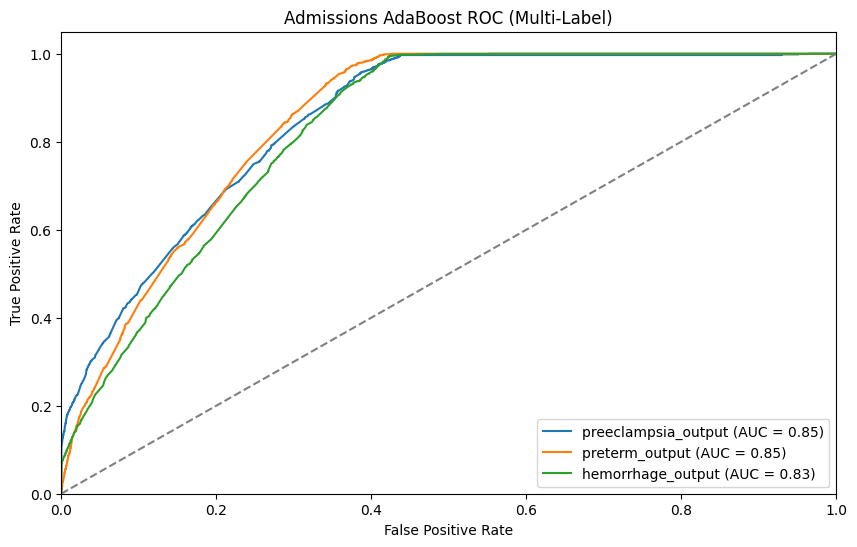

In [ ]:
gen_roc_curve_multi(y_test.values, y_prob, 'Admissions AdaBoost ROC (Multi-Label)', 'multi_admissions_ada_roc.png', y_multi_names)

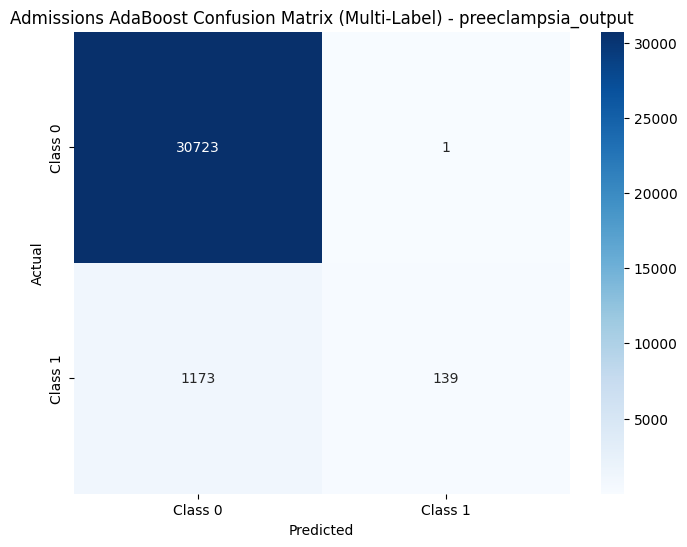

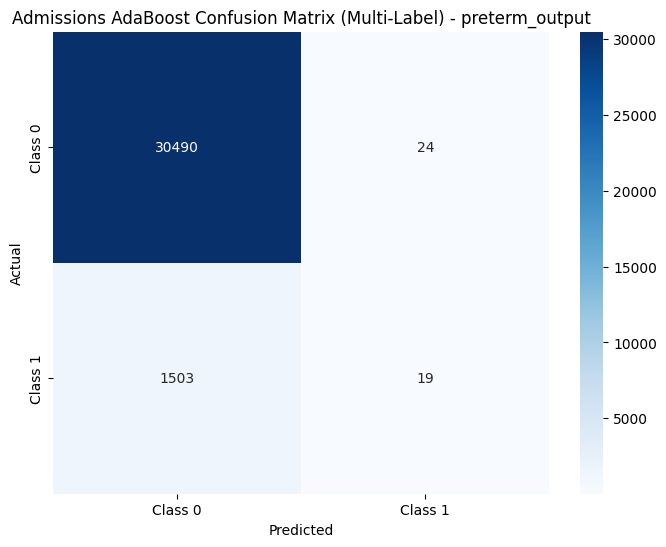

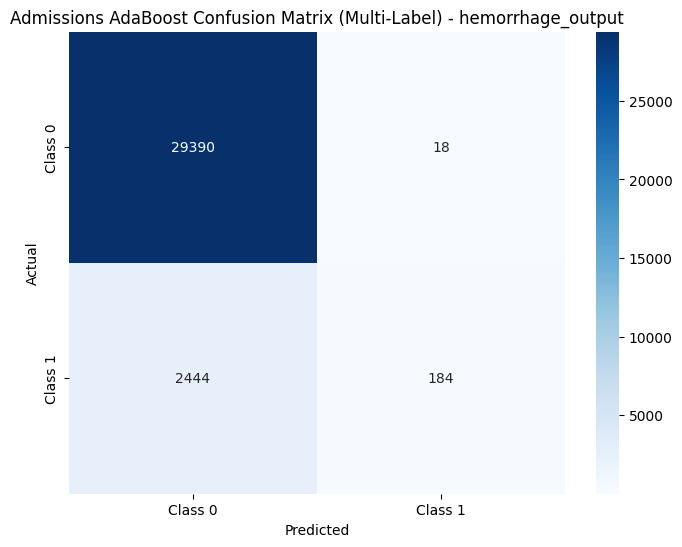

In [ ]:
gen_confusion_matrix_multi(y_test.values, y_pred, 'Admissions AdaBoost Confusion Matrix (Multi-Label)', 'multi_admissions_ada_matrix.png', y_multi_names)

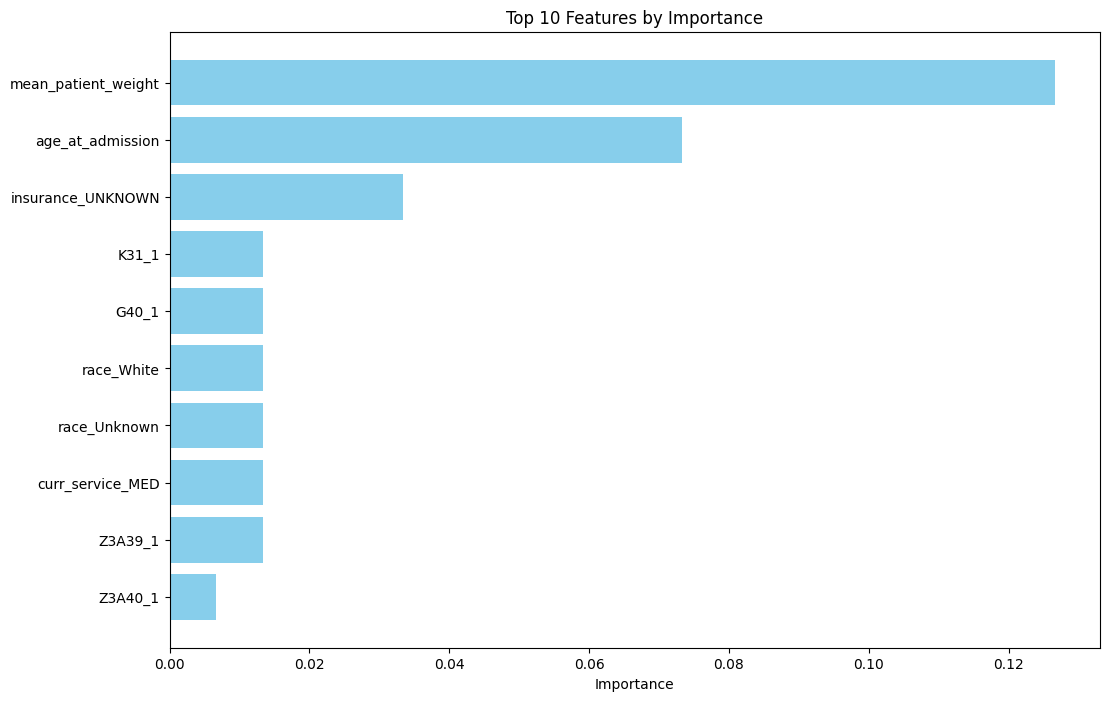

In [ ]:
gen_feature_importance_multi(pipeline, X, 'multi_admissions_ada_importance.png')

## AdaBoost Classifier with SMOTE on Aggregated Admissions

In [ ]:
# base estimator - use simple base estimator to avoid overfitting
base_estimator = DecisionTreeClassifier(max_depth=1)
# start with a modest number of estimators to reduce model complexity
ada_boost = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, random_state=23)
smote = SMOTE(random_state=23)

pipeline = Pipeline([
    ('smote', smote),
    ('classifier', ada_boost)
])

X_train, X_test, y_train, y_test = train_test_split(X_agg, y_agg, test_size=0.3, random_state=23)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
cv_results = cross_validate(pipeline, X_train, y_train, cv=cv,
                            scoring=['roc_auc', 'f1', 'recall'],
                            return_train_score=False)

print_cv_results(cv_results)

pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarnin

Cross-validation results, averaged over 5 folds:
Mean AUC: 0.8214991685647967
Mean recall: 0.5742751591516312


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Pipeline(steps=[('smote', SMOTE(random_state=23)),
                ('classifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                    random_state=23))])

In [ ]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

calc_metrics(y_test, y_pred, y_prob)

AUC: 0.8217040970920423
Recall: 0.5861321776814734
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      3911
           1       0.43      0.59      0.50       923

    accuracy                           0.77      4834
   macro avg       0.66      0.70      0.67      4834
weighted avg       0.80      0.77      0.78      4834

[[3190  721]
 [ 382  541]]


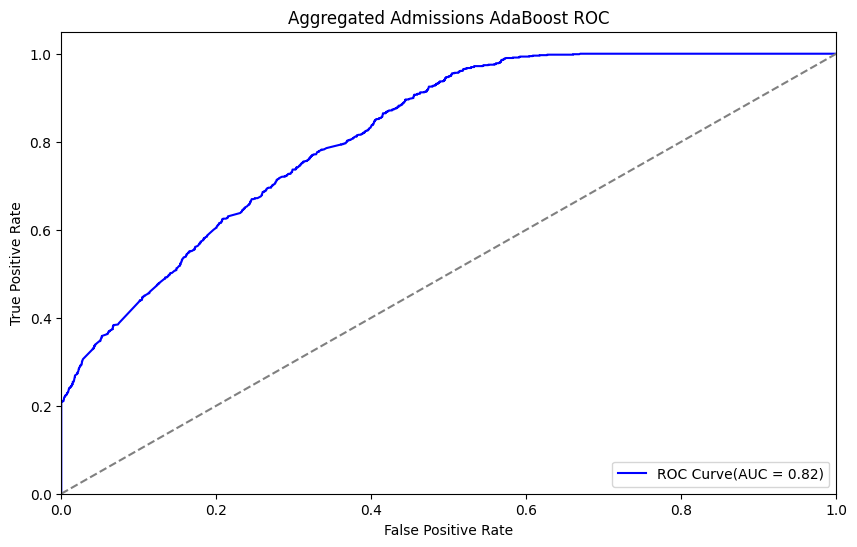

In [ ]:
gen_roc_curve(y_test, y_prob, 'Aggregated Admissions AdaBoost ROC', 'agg_admissions_ada_binary_roc.png')

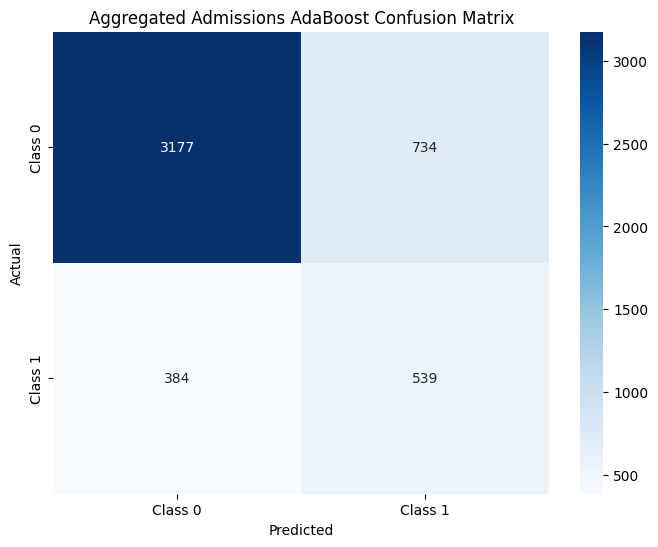

In [ ]:
gen_confusion_matrix(y_test, y_pred, 'Aggregated Admissions AdaBoost Confusion Matrix', 'agg_admissions_ada_binary_matrix.png')

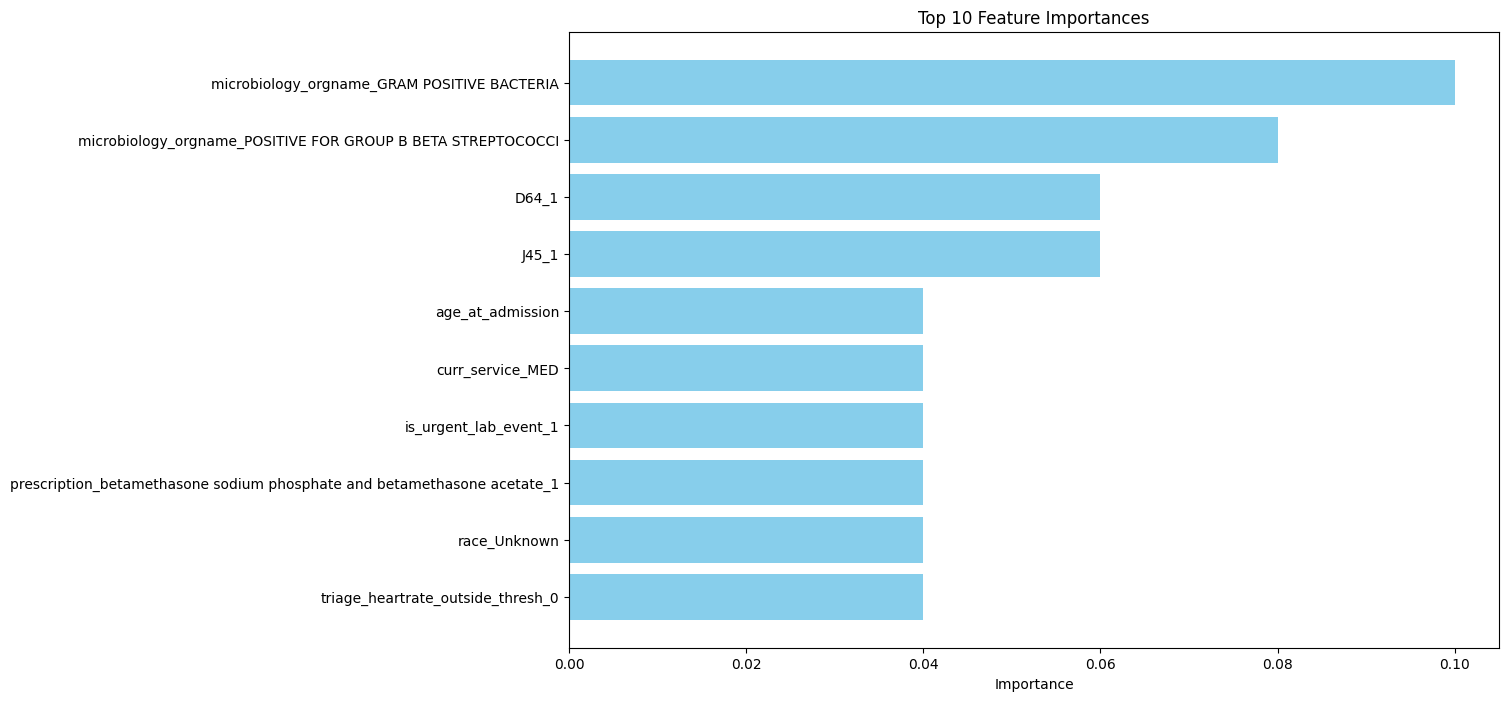

In [ ]:
gen_feature_importance(pipeline, X_agg, 'agg_admissions_ada_binary_importance.png')

## AdaBoost Classifier on Aggregated Admissions (Multi-Label Classifier)

In [ ]:
# base estimator - use simple base estimator to avoid overfitting
base_estimator = DecisionTreeClassifier(max_depth=1)
# start with a modest number of estimators to reduce model complexity
ada_boost = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, random_state=23)

# use MultiOutputClassifier to handle multilabel classification
multi_output_classifier = MultiOutputClassifier(ada_boost)
pipeline = Pipeline([
    ('classifier', multi_output_classifier)
])

X_train, X_test, y_train, y_test = train_test_split(X_agg, y_agg_multi, test_size=0.3, random_state=23)

cv = KFold(n_splits=5, shuffle=True, random_state=23)

cv_results = cross_validate(pipeline, X_train, y_train, cv=cv,
                            scoring={'roc_auc': auc_scorer, 'recall': recall_scorer},
                            return_train_score=False)

print_cv_results(cv_results)

pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

Cross-validation results, averaged over 5 folds:
Mean AUC: 0.8417630007357015
Mean recall: 0.26449876231683117


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Pipeline(steps=[('classifier',
                 MultiOutputClassifier(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                                                    random_state=23)))])

In [ ]:
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)
# reshape y_prob from list of arrays to 2D array
y_prob = np.array([prob[:, 1] for prob in y_prob]).T

calc_metrics_multi(y_test.values, y_pred, y_prob)

AUC: 0.8368218349238493
Recall: 0.2609291394576406
              precision    recall  f1-score   support

           0       0.89      0.46      0.61       289
           1       0.35      0.05      0.09       289
           2       0.87      0.27      0.41       532

   micro avg       0.82      0.26      0.40      1110
   macro avg       0.70      0.26      0.37      1110
weighted avg       0.74      0.26      0.38      1110
 samples avg       0.06      0.05      0.05      1110



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


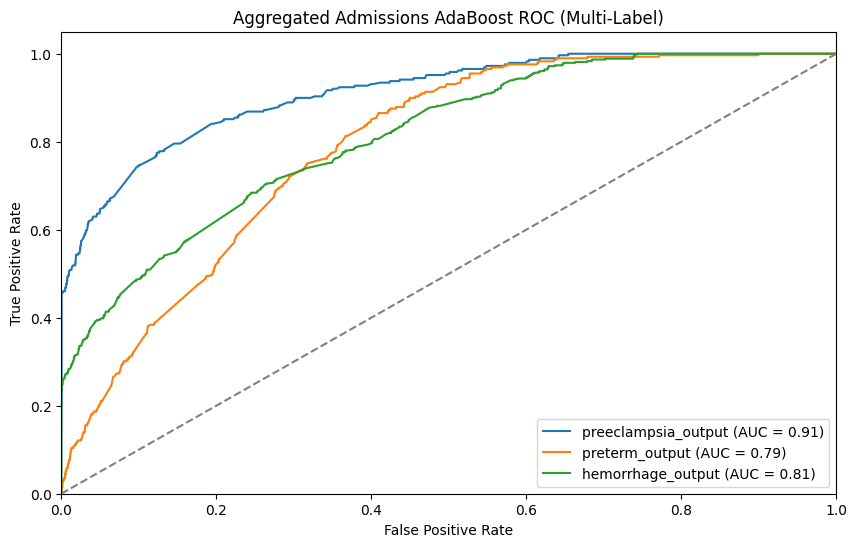

In [ ]:
gen_roc_curve_multi(y_test.values, y_prob, 'Aggregated Admissions AdaBoost ROC (Multi-Label)', 'agg_multi_admissions_ada_roc.png', y_agg_multi_names)

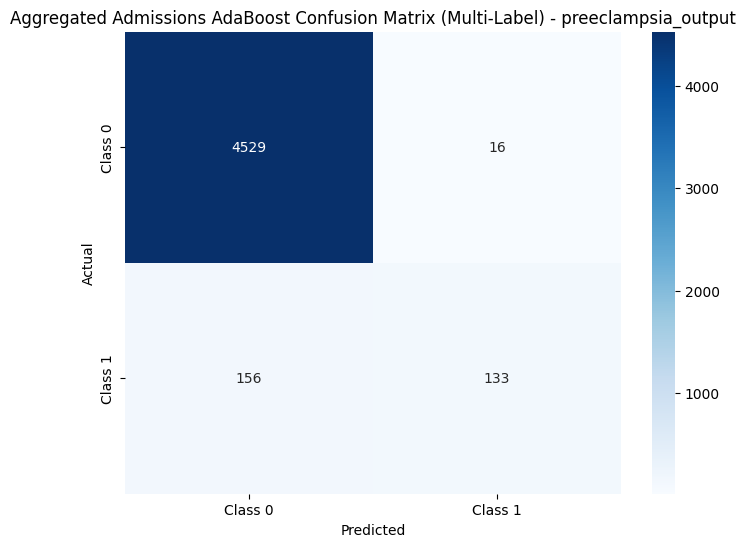

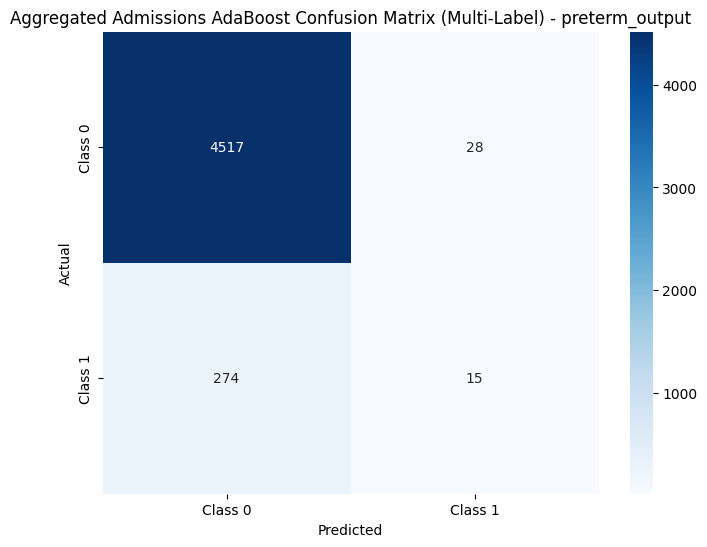

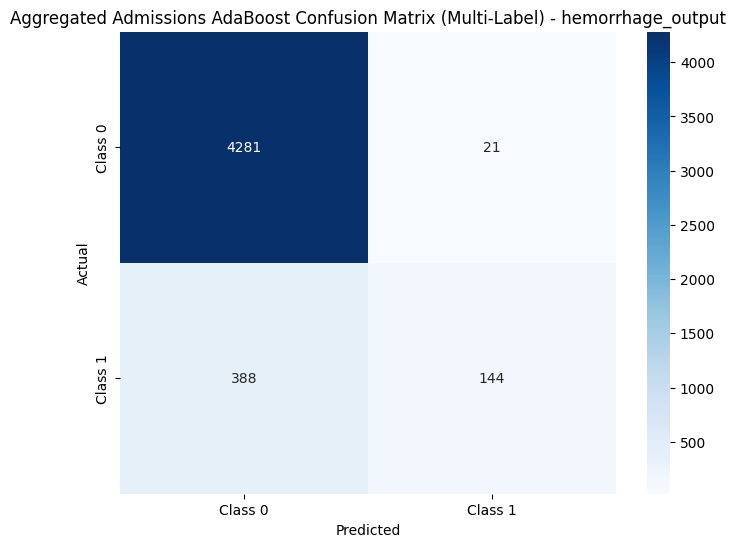

In [ ]:
gen_confusion_matrix_multi(y_test.values, y_pred, 'Aggregated Admissions AdaBoost Confusion Matrix (Multi-Label)', 'agg_multi_admissions_ada_matrix.png', y_agg_multi_names)

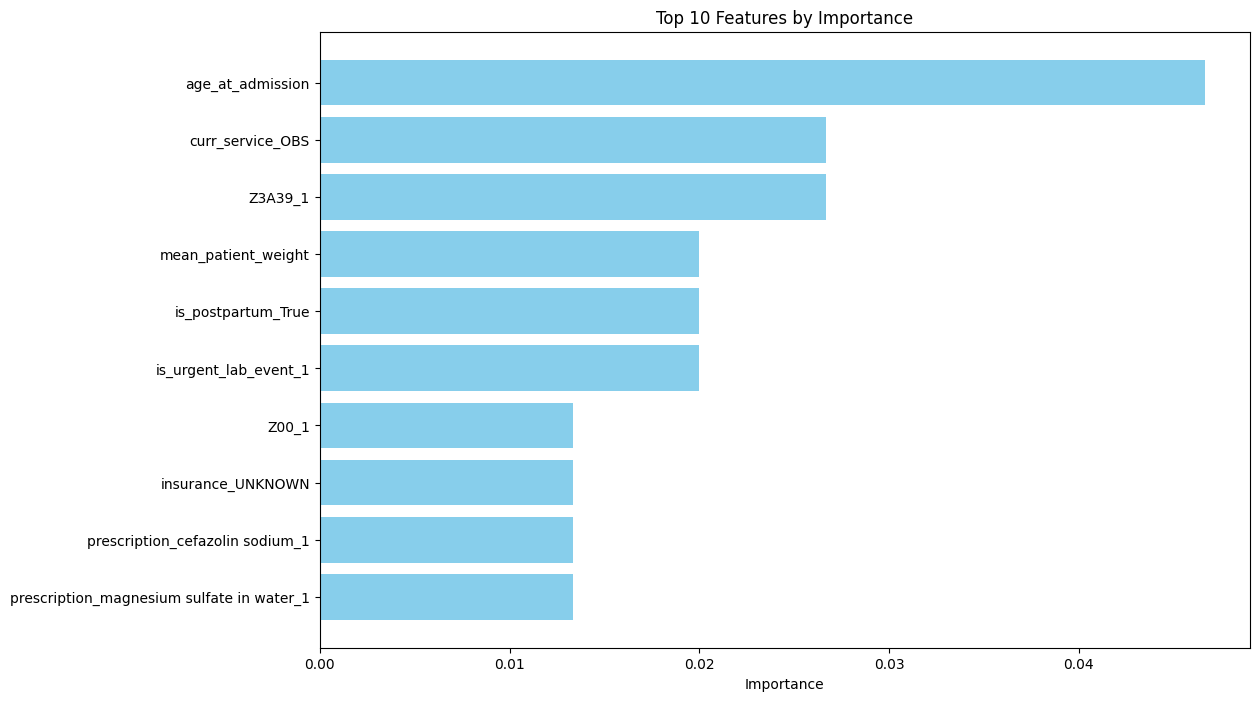

In [ ]:
gen_feature_importance_multi(pipeline, X_agg, 'agg_multi_admissions_ada_importance.png')